# Evaluate a trained encoder  

Notebook Author: Aniket Tekawade, Argonne National Laboratory, atekawade@anl.gov  

This notebook will run some tests on a trained encoder-decoder model to (1) visualize the latent space clusters (2) evaluate segmentation accuracy (3) something else (4) and something else.  

### Set paths and arguments  

In [1]:
from tensorflow.config.experimental import *
GPU_mem_limit = 16.0
gpus = list_physical_devices('GPU')
if gpus:
  try:
    set_virtual_device_configuration(gpus[0], [VirtualDeviceConfiguration(memory_limit=GPU_mem_limit*1000.0)])
  except RuntimeError as e:
    print(e)        

In [2]:
# paths
model_path = "/data02/MyArchive/aisteer_3Dencoders/models"
csv_path = "/data02/MyArchive/aisteer_3Dencoders/data_TomoTwin/datalist_train.csv"

# arguments
n_samples = 5000
model_tag = "111d32_set6"
noise_level = 0.18
patch_size = tuple([64]*3)
binning = 2
latent_dims = int(model_tag.split('_')[0].split('d')[-1])

In [3]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import h5py
import time

import matplotlib.pyplot as plt
import matplotlib as mpl

from tomo_encoders.img_stats import Parallelize, calc_jac_acc, pore_analysis
from tomo_encoders.data_sampling import data_generator_4D, get_data_from_flist
from tomo_encoders.porosity_encoders import custom_objects_dict
from tomo_encoders.latent_vis import *
from tomo_encoders.feature_maps_vis import view_midplanes

from tensorflow.keras.models import load_model
import pickle

figw = 8
import seaborn as sns
sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.grid' : False})

### Load the trained model  

In [4]:
model_names = {"segmenter" : "segmenter%s.hdf5"%model_tag, \
               "encoder" : "encoder%s.hdf5"%model_tag, \
               "PCA" : "PCA%s.pkl"%model_tag}

encoder = load_model(os.path.join(model_path, model_names["encoder"]), \
                     custom_objects = custom_objects_dict)
segmenter = load_model(os.path.join(model_path, model_names["segmenter"]), \
                     custom_objects = custom_objects_dict)

### Load the data and draw $64^3$ sized samples

In [5]:
Xs, Ys, plot_labels = get_data_from_flist(csv_path, \
                                       normalize = True,\
                                       data_tags = ("recon", "gt_labels"),\
                                       group_tags = ["tomo"],\
                                       downres = binning)

dg = data_generator_4D(Xs, Ys, \
                             patch_size, n_samples, \
                             scan_idx = True, add_noise = noise_level)
x, y, sample_labels = next(dg)
print("Shape of x: %s"%str(x.shape))

Shape of x: (5000, 64, 64, 64, 1)


**Histogram of sampled patches:** How many patches are drawn from each dataset?  

<AxesSubplot:ylabel='label'>

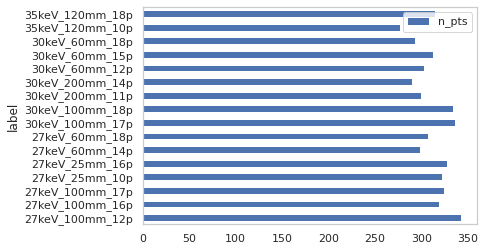

In [6]:
tmp_labels = [plot_label.split('train_blobs_')[-1] for plot_label in plot_labels]

sample_hist = pd.DataFrame(columns = ["label", "n_pts"])
sample_hist["label"] = tmp_labels
sample_hist = sample_hist.set_index("label")

for idx, sample_lab in enumerate(tmp_labels):
    sample_hist.loc[sample_lab, "n_pts"] = np.size(np.where(sample_labels == idx))    
# sample_hist
sample_hist.plot.barh()

### Get output from decoder and encoder  

**Encoder output** Get latent vector, then apply PCA.  

In [7]:
dfN = get_latent_vector(encoder, x, sample_labels, plot_labels)
pkl_filename = os.path.join(model_path, model_names["PCA"])

# Load from file
with open(pkl_filename, 'rb') as file:
    pca = pickle.load(file)

ncomps = 2
df = transform_PCA(dfN, latent_dims, pca, ncomps = ncomps)
df["${||{h}||}$"] = np.linalg.norm(dfN[["$h_%i$"%i for i in range(latent_dims)]], axis = 1)


df = rescale_z(df)

**Decoder output** How does the segmented output look?  

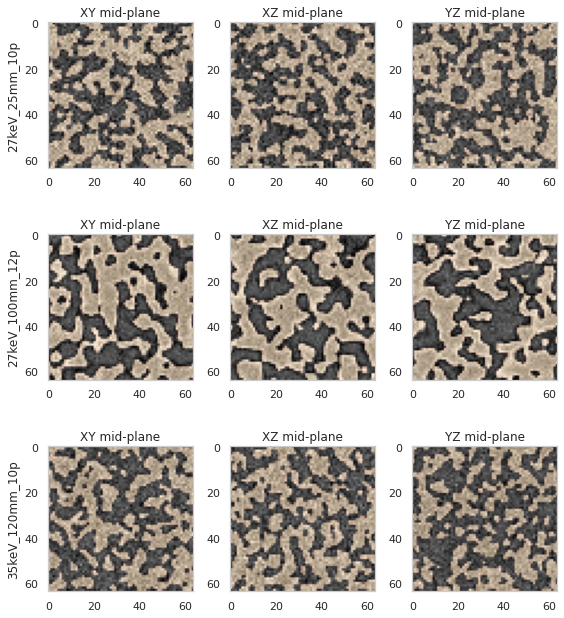

In [8]:
# accuracy of segmentation using intersection-over-union (IoU)
yp = segmenter.predict(x)
yp = np.round(yp)
df["IoU"] = Parallelize(list(zip(y, yp)), calc_jac_acc, procs = 48)

nplots = 3
fig, ax = plt.subplots(nplots,3, figsize = (8,3*nplots))
for ii in range(nplots):
    view_midplanes(vol = x[ii,...,0], ax = ax[ii])
    view_midplanes(vol = yp[ii,...,0], ax = ax[ii], cmap = "copper", alpha = 0.3)
    ax[ii,0].set_ylabel(tmp_labels[sample_labels[ii]])
fig.tight_layout()

**Calculate some metadata** to further understand cluster distances (future use)  

In [9]:
# ground-truth porosity values (calculated after applying connected components filter)
f = Parallelize(y, pore_analysis, procs = 48)
f = np.asarray(f)
df[["void-fraction", "npores", "pore-vol"]] = f
# df_temp = pd.DataFrame(columns = ["void-fraction", "npores", "pore-vol"], data = f)

# signal-to-noise ratio (SNR)  
f = Parallelize(list(zip(x,y)), calc_SNR, procs = 48)
f = np.asarray(f)
df_temp = pd.DataFrame(columns = ["SNR"], data = f.reshape(-1,1))
df["SNR"] = f

df.head()

,$z_0$,$z_1$,label,measurement,shape,param,${||{h}||}$,IoU,void-fraction,npores,pore-vol,SNR
0,-1.277480,0.807685,train_blobs_27keV_25mm_10p,27keV25mm,blobs,10.0,4.865821,0.893771,0.493996,35.0,11.663416,1.958995
1,0.750483,2.573021,train_blobs_27keV_100mm_12p,27keV100mm,blobs,12.0,9.662321,0.960586,0.483753,20.0,20.015101,2.367062
2,-2.151350,-0.086492,train_blobs_35keV_120mm_10p,35keV120mm,blobs,10.0,3.136550,0.900964,0.504765,36.0,11.640477,1.838151
3,0.325954,-2.574793,train_blobs_30keV_60mm_12p,30keV60mm,blobs,12.0,7.130035,0.935585,0.474945,14.0,26.843425,1.788203
4,-1.451066,0.483178,train_blobs_30keV_200mm_11p,30keV200mm,blobs,11.0,4.388170,0.936939,0.525364,22.0,18.784549,2.052951


### Analyze Segmentation Accuracy  

**Compare accuracy with porosity metrics:** Is accuracy sensitive to pore size?

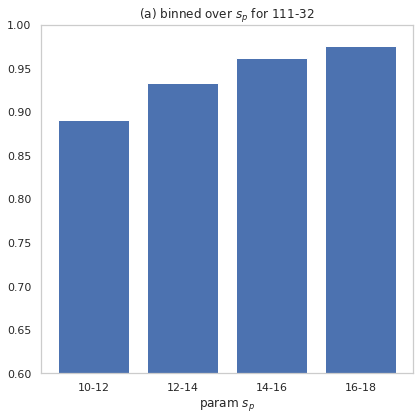

In [10]:
modelid = model_tag.split('_')[0].split('d')
modelid = ('-').join(modelid)

bins = ["10-12", "12-14", "14-16", "16-18"]
IoU_binned = []
IoU_binned.append(np.mean(df[df["param"].between(10,11,inclusive = True)]["IoU"]))
IoU_binned.append(np.mean(df[df["param"].between(12,13,inclusive = True)]["IoU"]))
IoU_binned.append(np.mean(df[df["param"].between(14,15,inclusive = True)]["IoU"]))
IoU_binned.append(np.mean(df[df["param"].between(16,18,inclusive = True)]["IoU"]))    

fig, ax = plt.subplots(1,1, figsize = (6,6), sharey = True)
ax.bar(bins, IoU_binned)
ax.set_xlabel("param $s_p$")
ax.set_title("(a) binned over $s_p$ for %s"%modelid)
ax.set_ylim([0.6,1.0])
fig.tight_layout()

**Compare accuracy with SNR:** Is accuracy sensitive to the SNR in input images?  

Min IoU in datasets: 0.87


Text(0.5, 1.0, 'Patches')

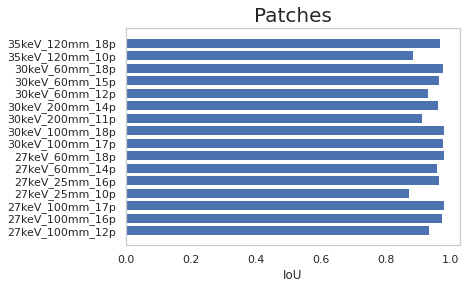

In [11]:
mean_IoUs = np.zeros(len(plot_labels))
for il, label in enumerate(plot_labels):
    mean_IoUs[il] = calc_jac_acc(y[sample_labels == il],\
                             yp[sample_labels == il])
plt.barh(tmp_labels, mean_IoUs)
plt.xlabel("IoU")    
print("Min IoU in datasets: %.2f"%mean_IoUs.min())
plt.title("Patches", fontsize = 20)

### Analyze the reduced latent (z) space  

**Plot PCA** Plot the 2D projection of latent space  

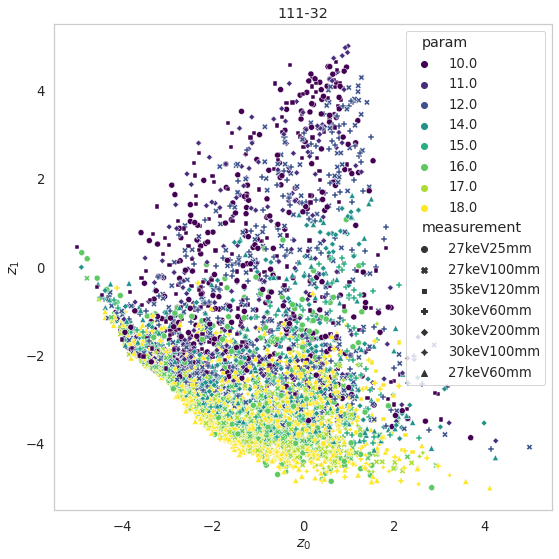

In [12]:
sns.set(font_scale = 1.2)
sns.set_style("whitegrid", {'axes.grid' : False})
fig, ax = plt.subplots(1,1,figsize = (8,8), sharex = True, sharey = True)

sns.scatterplot(data = df, x = "$z_0$", y = "$z_1$", \
                hue = "param", \
                palette = "viridis", ax = ax, \
                legend = 'full', \
                style = "measurement", )
modelid = model_tag.split('_')[0].split('d')
modelid = ('-').join(modelid)
ax.set_title("%s"%modelid)

fig.tight_layout()

**Compare** calculated porosity metrics with z-space. Npte that $s_p$ varies logarithmically with pore size (or number of pores per volume).  

In [13]:
df["log npores"] = np.log(df["npores"])
df["log pore-vol"] = np.log(df["pore-vol"])
df["${log(z_1)}$"] = np.log(df["$z_1$"])
df["${log(z_0)}$"] = np.log(df["$z_0$"])

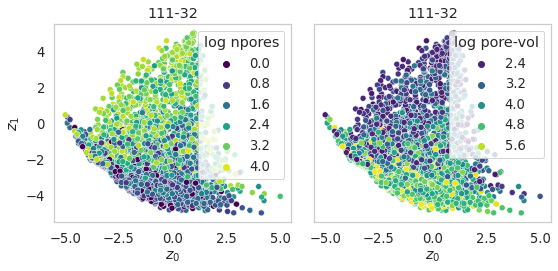

In [14]:
sns.set(font_scale = 1.2)
sns.set_style("whitegrid", {'axes.grid' : False})
fig, ax = plt.subplots(1,2,figsize = (8,4), sharex = True, sharey = True)

hues = ["log npores", "log pore-vol"] #["npores", "pore-vol"]
for idx, hue in enumerate(hues):
        
    sns.scatterplot(data = df, x = "$z_0$", y = "$z_1$", \
                    hue = hue, \
                    palette = "viridis", ax = ax.flat[idx], \
                    legend = 'brief')
    modelid = model_tag.split('_')[0].split('d')
    modelid = ('-').join(modelid)
    ax.flat[idx].set_title("%s"%modelid)
fig.tight_layout()

### Analyze Compute Times  

In [15]:
niters = 4000
idx = 10

**Pore analysis** (connected components)

In [16]:
t0 = time.time()
output = [pore_analysis(y[idx]) for idx in range(niters)]
t1 = time.time()
tot_time = (t1-t0)*1000.0/niters

print(tot_time)

5.5725137591362


**Segmentation** (encoder+decoder) - this could vary significantly based on available GPU memory  

In [17]:
x_in = x[:niters]
t0 = time.time()
yp_temp = segmenter.predict(x_in)
t1 = time.time()
tot_time = (t1-t0)*1000.0/niters
print(tot_time)

29.21665620803833


**Encoder**

In [18]:
x_in = x[:niters]
t0 = time.time()
yp_temp = encoder.predict(x_in)
t1 = time.time()
tot_time = (t1-t0)*1000.0/niters
print(tot_time)

10.570538699626923


### THE END